Farutin Vadim

Homework02

In [11]:
import numpy as np
import operator
import csv

Reading datasets.

In [30]:
def read_spam():
    D = []
    
    with open('./Datasets/spam.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array([np.array(row[:-1]), row[-1]]))

    return np.array(D)

In [31]:
def read_cancer():
    D = []
    
    with open('./Datasets/cancer.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            D.append(np.array([np.array(list(map(float, row[1:]))), row[0]]))

    return np.array(D)

In [32]:
def read_blobs():
    D = []
    
    with open('./Datasets/blobs.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array(row))

    return np.array(D)

In [33]:
def read_blobs2():
    D = []
    
    with open('./Datasets/blobs2.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array([np.array(row[:-1]), row[-1]]))

    return np.array(D)

In [34]:
def extract_labels(D):
    X = np.array([row[0] for row in D])
    Y = np.array([row[1] for row in D])
    
    return X, Y

In [35]:
from sklearn.model_selection import train_test_split

def split_dataset(D, train_size):
    X, Y = extract_labels(D)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, test_size=1 - train_size)
    D_train = np.array([[x_row, y_row] for x_row, y_row in zip(X_train, Y_train)])
    D_test = np.array([[x_row, y_row] for x_row, y_row in zip(X_test, Y_test)])
    
    return D_train, D_test

VC-theory


1. (2 points) Identify breakpoints, VC-dimensions and growth functions of following hypotheses:

a) h(x) = +1 if x_i > a 

b) h(x) = +1 if a < x_i < b

Perceptron

Dataset: blobs2.csv.

2. (4 points) Implement the pocket perceptron algorithm. Train-test split the dataset (80%/20%). Train the algorithm on train points and find the best performing line on test points. Find the best perceptron. Draw dataset points and the resulting line.

In [37]:
def perceptron_clusters(X, h):
    return np.array([h(x) for x in X])

In [38]:
def perceptron_error(X, Y, h):
    return np.mean(perceptron_clusters(X, h) != Y)

In [39]:
from sklearn.preprocessing import PolynomialFeatures

def pocket_perceptron(D, degree, iter_num):
    D_train, D_test = split_dataset(D, 0.8)
    X_train, Y_train = extract_labels(D_train)
    X_train_extended = PolynomialFeatures(degree=degree).fit_transform(X_train)
    X_test, Y_test = extract_labels(D_test)
    X_test_extended = PolynomialFeatures(degree=degree).fit_transform(X_test)

    w = np.random.rand(len(X_train_extended[0]))
    def h(w):
        return lambda x: 0 if np.sign(np.dot(w, x)) < 0 else 1
    
    best_w = w
    best_error = perceptron_error(X_test_extended, Y_test, h(w))
    
    for i in range(iter_num):
        for x, y in zip(X_train_extended, Y_train):
            if h(w)(x) != y:
                w = w + (2 * y - 1) * x
                error = perceptron_error(X_test_extended, Y_test, h(w))

                if error < best_error:
                    best_w = w
                    best_error = error
    
    return h(w)

In [44]:
import matplotlib.pyplot as plt

# Most part of this code is taken from sklearn example:
# https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def plot_perceptron(D, h, degree):
    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        return xx, yy


    def plot_contours(ax, h, xx, yy, **params):
        Z = perceptron_clusters(PolynomialFeatures(degree=degree).fit_transform(np.c_[xx.ravel(), yy.ravel()]),
                                h)
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out

    X, Y = extract_labels(D)
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    fig, ax = plt.subplots()
    
    plot_contours(ax, h, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    plt.show()

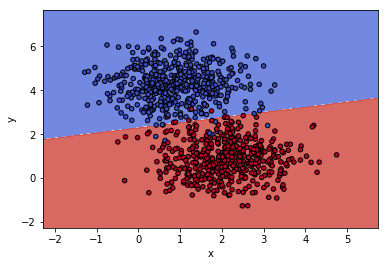

In [42]:
D = read_blobs2()
degree = 1
iter_num = 100
h = pocket_perceptron(D, degree, iter_num)
plot_perceptron(D, h, degree)

3. (4 points) Add second-degree polynomial features to the dataset (x_1^2, x_2^2, x_1x_2), find the best perceptron hyperplane. Draw a projection of the hyperplane to the original two-dimensional space. Repeat for third- and fourth-degree polynomial features.


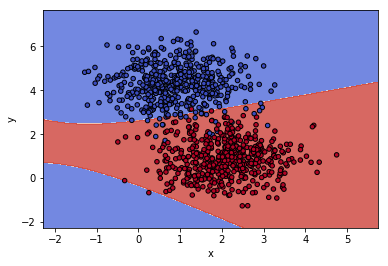

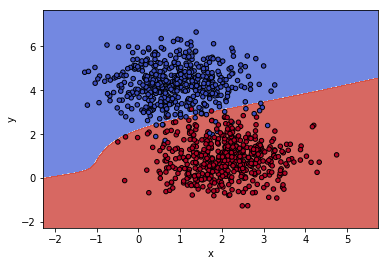

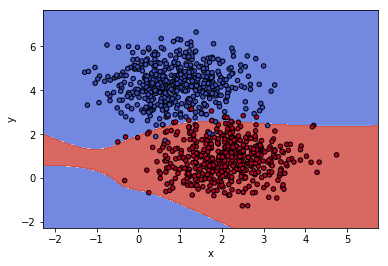

In [43]:
D = read_blobs2()
iter_num = 100

for degree in range(2, 5):
    h = pocket_perceptron(D, degree, iter_num)
    plot_perceptron(D, h, degree)

Logistic regression

Datasets: cancer.csv, spam.csv.

4. (4 points) Implement the logistic regression algorithm. Train it via the stochastic gradient descent and output draw the accuracy/iteration curve.

In [12]:
def logistic_regression_clusters(X, h):
    return np.array([h(x) for x in X])

In [13]:
def logistic_regression_error(X, Y, h):
    return np.mean(logistic_regression_clusters(X, h) != Y)

In [121]:
from sklearn.preprocessing import MinMaxScaler
    
def logistic_regression(D, epoch_num, batch_size):
    X, Y = extract_labels(D)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    Y_renamed = np.zeros(len(Y))
    Y_renamed[Y == Y[0]] = -1
    Y_renamed[Y != Y[0]] = 1
    
    w = np.random.rand(len(X[0]))
    accuracies = np.empty(epoch_num)
    
    def sigma(s):
        return 1 / (1 + np.exp(-s))
    
    def sgd(w):
        return lambda x, y: y / (1 + np.exp(y * np.dot(w, x))) * x
    
    def h(w):
        return lambda x: -1 if sigma(np.dot(w, x)) < 0.5 else 1
    
    batches = [range(batch_size * i, 
                     min(batch_size * (i + 1), len(D))) 
               for i in range((len(D) + batch_size - 1) // batch_size)]
    
    for i in range(epoch_num):
        for batch in batches:
            batch_sum = 0
            
            for j in batch:
                batch_sum += sgd(w)(X[j], Y_renamed[j])
            
            w = w - (- batch_sum / len(batch))
        
        accuracies[i] = 1.0 - logistic_regression_error(X, Y_renamed, h(w))
    
    return accuracies

In [122]:
import matplotlib.pyplot as plt

def plot_logistic_regression_curve(accuracies):
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.plot(list(range(len(accuracies))), accuracies)
    plt.show()

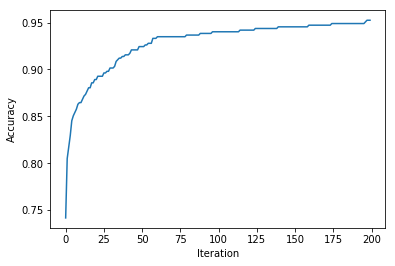

In [123]:
D = read_cancer()
epoch_num = 200
batch_size = 32
accuracies = logistic_regression(D, epoch_num, batch_size)
plot_logistic_regression_curve(accuracies)

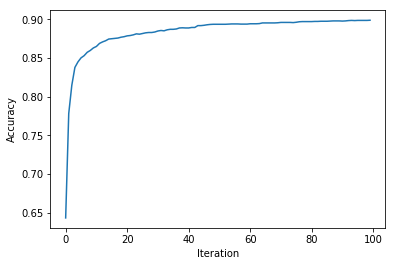

In [124]:
D = read_spam()
epoch_num = 100
batch_size = 32
accuracies = logistic_regression(D, epoch_num, batch_size)
plot_logistic_regression_curve(accuracies)

Neural networks

Datasets: mnist.csv, notMNIST.tar.gz

5. (2 points) Prepare the datasets so that every point is represented by a two-dimensional tensor.


In [ ]:
def read_mnist():
    D = []
    
    with open('./Datasets/mnist.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            D.append(np.array([np.array(list(map(float, row[1:]))), row[0]]))

    return np.array(D)

6. (4 points) Create a neural network that consists out of three convolutional layers with 8 3x3 filters each and two fully-connected layers with 64 neurons each. Train the network on the mnist dataset with three different types of activation functions (sigmoid, tanh, ReLU).

7. (3 points) Reach an accuracy of 90% on the notMNIST test dataset. All techniques are permitted.

8. (3 points) Reach an accuracy of 95% on the notMNIST test dataset. All techniques are permitted.